# Converting Text to Numbers for Natural Language Processing
Date: 2019-11-20  
Author: Jason Beach  
Categories: DataScience, DeepLearning  
Tags: nlp, spacy, python  
<!--eofm-->

We will be making use of the following modules:

* numpy - numerical computation
* spacy / nltk - word processing
* gensim - model implementation
* fasttext - word vectors
* keras (tensorflow)


_References_

* [doc: spacy similarity](https://spacy.io/usage/vectors-similarity)
* [ref: skip-gram training with numpy](https://towardsdatascience.com/word2vec-from-scratch-with-numpy-8786ddd49e72)
* [ref: performance comparison](https://github.com/TomLin/Playground/blob/master/04-Model-Comparison-Word2vec-Doc2vec-TfIdfWeighted.ipynb)
* [ref: explore cosing similiarity](http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/)
* [ref: comparison of word vectors](https://github.com/TomLin/Playground/blob/master/04-Model-Comparison-Word2vec-Doc2vec-TfIdfWeighted.ipynb)
* [app: explore embeddings with graph](https://github.com/anvaka/word2vec-graph)


## Introduction

Discussion and references from multiple sources in `@@Deep Learning for NLP`

Word embedding just represents words with numbers.  Word2vec is a neural network structure to generate word embedding by training the model on a supervised classification problem. Such a method was first introduced in the paper [Efficient Estimation of Word Representations in Vector Space by Mikolov et al.,2013](https://arxiv.org/pdf/1301.3781.pdf) and was proven to be quite successful in achieving word embedding that could used to measure syntactic and semantic similarities between words.

Although one-hot encoding is quite simple, there are several downsides. The most notable one is that it is not easy to measure relationships between words in a mathematical way.  Also, the matrix used would have to be huge (~1M columns) to contain a quality number of words.



## Application

A word vector is a table of numbers, with one row per term in your vocabulary.  If two terms are used in similar contexts, the algorithm that learns the vectors should assign them rows that are quite similar.  Word vectors should be discussed when used on the 'word', 'sentence', and 'document' levels. 

When training models, word vectors are useful in the context of Named Entity Recognition.  Although training data may not have an instance of a specific NE, two similar entities should have similar vectors.  So, training without the full domain of possible NEs should not effect the model too adversely.

Word usage has a Pareto distribution where most words are rare, so most of the rows in a large word vectors table will be accessed very rarely, or never at all. You can usually cover more than 95% of the tokens in your corpus with just a few thousand rows in the vector table.  Adding more rows of words has rapidly diminishing returns.

Custom word vectors can be trained using a number of open-source libraries, such as Gensim, Fast Text, or Tomas Mikolov’s [original word2vec implementation](https://code.google.com/archive/p/word2vec/).



In order to use similarity, you need a larger spaCy model that has word vectors included (`en_core_web_lg`, `en_core_web_md` – but not `_sm`).  That is because `similarity` is determined using word vectors.  Word vectors are generated using an algorithm like Word2Vec and lots of text.  The default distance is `cosine` similarity, but can be adjusted.

![cosine similarity](images/nlp-wordembed_cosinesim.png)

For a more in-depth look, the [source code](https://spacy.io/docs/usage/word-vectors-similarities) for `.similarity` shows:

`return numpy.dot(self.vector, other.vector) / (self.vector_norm * other.vector_norm)`

### Usage in SpaCy

Spacy's `en_vectors_web_lg` model provides 300-dimensional GloVe vectors for over 1 million terms of English.

In [1]:
#! python -m spacy download en_core_web_lg --force

In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
import spacy

nlp = spacy.load("en_core_web_lg")
tokens = nlp("dog cat banana afskfsd")

In [38]:
print( tokens[2] )
print( tokens[2].has_vector )
print( tokens[2].is_oov )
print( tokens[2].vector.shape )
print( tokens[2].vector[0:20] )

banana
True
False
(300,)
[ 0.20228  -0.076618  0.37032   0.032845 -0.41957   0.072069 -0.37476
  0.05746  -0.012401  0.52949  -0.5238   -0.19771  -0.34147   0.53317
 -0.025331  0.1738    0.16772   0.83984   0.055107  0.10547 ]


In [53]:
from scipy.spatial.distance import cosine

#similarity = 1 - cosine_distance
1 - cosine(tokens[0].vector, tokens[1].vector)

0.8016855120658875

In [39]:
print( "Within animals: ", tokens[0].similarity(tokens[1]) )
print( "Between animals and fruit: ", tokens[1].similarity(tokens[2]) )

Within animals:  0.80168545
Between animals and fruit:  0.2815437


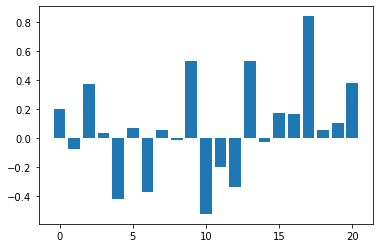

In [52]:
ax_x = np.array(range(21))
plt.bar(ax_x,  tokens[2].vector[0:21])
plt.show()

In [56]:
#document-level
# use list comprehension to get the vectors for each word
word_vector_list = [tok.vector for tok in tokens]

# calculate the mean across each word
average_word_vector = np.mean(word_vector_list, axis=0)

# check that the sum is the same as the other way
print(average_word_vector.sum())

-0.79927266


In [55]:
np.sum(tokens.vector)

-0.79927266

In [67]:
#remove stop words, so that only most important are used
strong_words = [tok for tok in tokens if tok.is_stop == False]
strong_words

[dog, cat, banana, afskfsd]

Reduce 300 dimensions to just 2 using PCA.

In [68]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

# this is just making sure we have loaded in our word vectors
if 'nlp' not in locals():
    nlp = spacy.load('en_core_web_lg')

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['car', 'truck', 'dragon', 'data', 'horse', 'fish' , 'lion']

# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components=2)

# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.
pca.fit(get_word_vectors(words))

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.
word_vecs_2d = pca.transform(get_word_vectors(words))

# let's look at our new 2D word vectors
word_vecs_2d

array([[ 4.09993372, -2.28173842],
       [ 3.59422001, -2.38095955],
       [-3.54300949, -0.36220067],
       [ 2.59345655,  6.11416944],
       [-1.08535571, -1.63163824],
       [-2.43593785,  0.95236696],
       [-3.22330723, -0.40999952]])

Reasonable locations on the two dimensional scale.

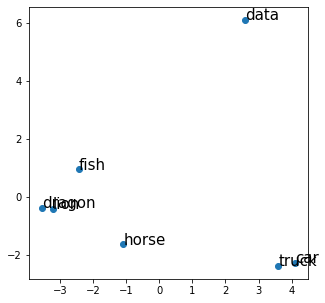

In [70]:
# create plot 
plt.figure(figsize=(5,5))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot
plt.show()

### Prepare vector for use with SpaCy

Convert the vectors model into a binary format that loads faster and takes up less space on disk.

This code outputs a spaCy model in the directory `/tmp/la_vectors_wiki_lg`.  Then load it into spacy.  The model directory will have a /vocab directory with the strings, lexical entries and word vectors from the input vectors model. 

spaCy’s `Vectors` class lets you map multiple keys to the same row of the table. If you’re using the `spacy init-model` command to create a vocabulary, pruning the vectors will be taken care of automatically if you set the `--prune-vectors` flag.  `Vocab.prune_vectors` reduces the current vector table to a given number of unique entries, and returns a dictionary containing the removed words, mapped to (string, score) tuples.

With spacy's `vector` class, data is stored in two structures:

* an array, which can be either on CPU or GPU.
* a dictionary mapping string-hashes to rows in the table.

In [ ]:
#! wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/word-vectors-v2/cc.la.300.vec.gz  

In [ ]:
#! python -m spacy init-model en /tmp/la_vectors_wiki_lg --vectors-loc cc.la.300.vec.gz

In [ ]:
#! python -m spacy init-model en /tmp/la_vectors_wiki_lg --prune-vectors --vectors-loc cc.la.300.vec.gz

In [ ]:
nlp_latin = spacy.load("/tmp/la_vectors_wiki_lg")
doc1 = nlp_latin("Caecilius est in horto")
doc2 = nlp_latin("servus est in atrio")
doc1.similarity(doc2)

If you’re using a GPU, it’s much more efficient to keep the word vectors on the device.

In [ ]:
import torch
from spacy.vectors import Vectors

vector_table = numpy.zeros((3, 300), dtype="f")
vectors = Vectors(["dog", "cat", "orange"], vector_table)
vectors.data = torch.Tensor(vectors.data).cuda(0)

### Basic comparisons

In [72]:
# Load a larger model with vectors
nlp = spacy.load('en_core_web_lg')

# Compare two documents
doc1 = nlp("I like fast food")
doc2 = nlp("I like pizza")
print("Personal like (2 words in common): ", doc1.similarity(doc2))

doc = nlp("I like pizza and pasta")
token1 = doc[2]
token2 = doc[4]
print("Within food: ", token1.similarity(token2))

0.8627203210548107
0.7369546


In [118]:
nlp = spacy.load('en_core_web_sm')
doc1 = nlp("I")
print( doc1.vector.shape )

(96,)


In [119]:
nlp = spacy.load('en_core_web_lg')
doc1 = nlp("I")
print( doc1.vector.shape )

(300,)


In [122]:
nlp = spacy.load('en_core_web_sm')

doc1 = nlp("I")
doc2 = nlp("like")
doc3 = nlp("I like")
doc4 = nlp("I like pizza")

print( doc1.vector.shape, ' ', doc1.vector_norm )
print( doc2.vector.shape, ' ', doc2.vector_norm )
print( doc3.vector.shape, ' ', doc3.vector_norm )
print( doc4.vector.shape, ' ', doc4.vector_norm )

(96,)   23.1725315055188
(96,)   21.75560300132138
(96,)   17.23478412191207
(96,)   14.848700829346688


In [130]:
doc1[0].vector == doc3[0].vector

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [112]:
print( np.dot(doc1.vector, doc2.vector) )
print( np.linalg.norm(doc2.vector, ord=2) )
print( np.linalg.norm(doc1.vector, ord=2) == np.linalg.norm(doc2.vector, ord=2) )
print( doc2.vector_norm )

21.871986
4.6767497
True
4.676749731219555


In [87]:
doc1 = nlp("pizza like I")
doc2 = nlp("I like pizza")
doc3 = nlp("pizza I like")
doc4 = nlp("like pizza I")
doc5 = nlp("I pizza like")
doc6 = nlp("like I pizza")

lDoc = [doc1, doc2, doc3, doc4, doc5, doc6]
result = np.zeros((6,6))
for i,doc1 in enumerate(lDoc):
    for j, doc2 in enumerate(lDoc):
        result[i,j] = doc1.similarity(doc2)

In [88]:
result

array([[1.        , 0.99999994, 0.99999994, 0.99999995, 0.99999994,
        0.99999994],
       [0.99999994, 1.        , 0.99999993, 0.99999994, 0.99999993,
        0.99999992],
       [0.99999994, 0.99999993, 1.        , 0.99999994, 0.99999993,
        0.99999993],
       [0.99999995, 0.99999994, 0.99999994, 1.        , 0.99999994,
        0.99999994],
       [0.99999994, 0.99999993, 0.99999993, 0.99999994, 1.        ,
        0.99999993],
       [0.99999994, 0.99999992, 0.99999993, 0.99999994, 0.99999993,
        1.        ]])

In [135]:
nlp = spacy.load('en_core_web_lg')

doc1 = nlp("apples oranges fruit")
print( doc1[0].vector_norm )
print( doc1[1].vector_norm )
print( doc1[2].vector_norm )

print( doc1[0].similarity(doc1[1]))
print( doc1[0].similarity(doc1[2]))

6.895898
6.949064
7.294794
0.77809423
0.72417974


In [138]:
doc1 = nlp("apples")
doc2 = nlp("apples apples apples apples apples apples apples apples apples apples apples apples apples apples apples apples apples apples")

print(doc1.vector_norm)
print(doc2.vector_norm)
print(doc1.similarity(doc2))

6.895897646384268
6.895897762990182
1.0000000930092277


In [137]:
doc1 = nlp("apples fruit")
doc2 = nlp("apples apples apples apples apples apples apples apples apples apples apples apples apples apples apples apples apples apples fruit")

print(doc1.vector_norm)
print(doc2.vector_norm)
print(doc1.similarity(doc2))

6.588359567392134
6.816139083280562
0.9383865534490474


In [64]:
# Load a larger model with vectors
#nlp = spacy.load('en_core_web_lg')

doc = nlp("I have a banana")
# Access the word vector via the token.vector attribute
vector = doc[3].vector
print( type(vector) )
print( vector.shape)

<class 'numpy.ndarray'>
(300,)


In [70]:
vector[0:10]

array([ 0.20228 , -0.076618,  0.37032 ,  0.032845, -0.41957 ,  0.072069,
       -0.37476 ,  0.05746 , -0.012401,  0.52949 ], dtype=float32)

In [71]:
#no universal definition for similarity 
doc1 = nlp("I like cats")
doc2 = nlp("I hate cats")

print(doc1.similarity(doc2))

0.9501447503553421


## Word Emeddings in Practice

### Using FastText

### Performance comparisons

## Understanding Word Embeddings

In Mikolov et al.,2013, two inverse model architectures were presented, 'Continuous Bag-of-Words' model and 'Skip-gram' model.  Skip gram will be discussed here.  Given a 'context word', we want to train a model such that the model can predict a 'target word', one of the words appeared within a predefined window size from the context word.

![Skip-gram model](images/nlp-wordembed_skipgram.png)

The word embedding layer is essentially a matrix with a shape of (# of unique words in the corpus, word embedding size). Each row of the matrix represent a word in the corpus. Word embedding size is a hyper-parameter to be decided and can be thought as how many features that we would like to use to represent each word. The latter part of the model is simply a logistic regression in a neural network form.

In the training process, the word embedding layer and the dense layer are being trained such that the model is able to predict target words given a context word at the end of the training process. After training such a model with a huge amount of data, the word embedding layer will end up becoming a representation of words which could demonstrate many kinds of cool relationships between words in a mathematical way. (Those who are interested in more details can refer to the original paper.)

### Typical model-training with Gensim

### Manual steps using Numpy

* [ref: notebook](https://github.com/ujhuyz0110/wrd_emb/blob/master/word2vec_skipgram_medium_v1.ipynb)
* [ref: derive gradient](https://github.com/ujhuyz0110/notes/blob/master/softmax_gradient.pdf)

_Generate training data_

1. tokenize
2. index by assigning integer to each
3. create training data

_Training process_

4. initialize weights (parameters that we want to train)
5. propagate forward
  - obtain input word’s vector representation from word embedding
  - pass the vector to the dense layer
  - apply softmax function to the output of the dense layer
6. calculate the cost
7. propagate backward, and update the weights
8. iterate for a number of cycles


Tokenize and mapping are here.

In [18]:
import re


def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

generate training data for the model. For each context word tokens[i], generate: (tokens[i], tokens[i-window_size]), ..., (tokens[i], tokens[i-1]), (tokens[i], tokens[i+1]), ..., (tokens[i], tokens[i+window_size])

In the code, the training (x, y) pairs are represented in word ids.

In [19]:
def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)

    return X, Y

Create training data.

In [21]:
import numpy as np

doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."
tokens = tokenize(doc)
word_to_id, id_to_word = mapping(tokens)
X, Y = generate_training_data(tokens, word_to_id, 3)
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

There are two layers in the model needed to be initialized and trained, the word embedding layer and the dense layer.

The shape of the word embedding will be (vocab_size, emb_size) . Why is that? If we’d like to use a vector with emb_size elements to represent a vocabulary and the total number of vocabularies our corpus is vocab_size, then we can represent all the vocabularies with a vocab_size x emb_size matrix with each row representing a word.

The shape of the dense layer will be (vocab_size, emb_size) . How come? The operation that would be performed in this layer is a matrix multiplication. The input of this layer will be (emb_size, # of training instances)and we’d like the output to be (vocab_size, # of training instances)(For each word, we would like to know what the probability that the word appears with the given input word). Note: I do not include biases in the dense layer.

Code for initialization.

In [22]:
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    return W

def initialize_parameters(vocab_size, emb_size):
    """
    initialize all the trianing parameters
    """
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

![Forward Propagate](images/nlp-wordembed_fwdprop.png)

In some literatures, the input is presented as a one-hot vector (Let’s say an one-hot vector with i-th element being 1). By multiplying the word embedding matrix and the one-hot vector, we can get the vector representing the input word. However, the result of performing matrix multiplication is essentially the same as selecting the ith row of the word embedding matrix. We can save lots of computational time by simply selecting the row associating with the input word.

The rest of the process is just a multi-class linear regression model.
The following graph could be used to recall the main operation of the dense layer.

Afterwards, we apply softmax function to the output of the dense layer which gives us the probability of each word appearing near the given input word. The following equation could be used to remind what softmax function is.

Code for forward propagation.

In [23]:
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

Here, we would use cross entropy to calculate cost:

In [25]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

During the back propagation process, we would like to calculate gradients of the trainable weights with respect to the loss function and update the weight with its associated gradient. Back propagation is the methods used to calculate those gradients. It is nothing fancy but chain rule in Calculus:

![Backward Propagate](images/nlp-wordembed_backwardprop.png)

In [26]:
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    WRD_EMB = parameters['WRD_EMB']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    WRD_EMB[inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

Repeat for many epocs

In [27]:
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    WRD_EMB = parameters['WRD_EMB']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    WRD_EMB[inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

In [29]:
from datetime import datetime

import matplotlib.pyplot as plt


def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=False, plot_cost=True):
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print('training time: {}'.format(end_time - begin_time))
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

In [ ]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)

In [31]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s neighbor words: {}".format(input_word, output_words))

of's neighbor words: ['the', 'of', 'costs', 'beating']
costs's neighbor words: ['beating', 'of', 'deduction', 'the']
is's neighbor words: ['game', 'market', "loser's", 'stock']
game's neighbor words: ['is', "loser's", 'a', 'beating']
beating's neighbor words: ['market', 'stock', 'costs', 'investing']
a's neighbor words: ['game', 'market', "loser's", 'stock']
the's neighbor words: ['is', 'of', 'beating', 'stock']
loser's's neighbor words: ['game', 'market', "loser's", 'stock']
market's neighbor words: ['is', "loser's", 'a', 'beating']
stock's neighbor words: ['investing', 'a', 'is', 'beating']
deduction's neighbor words: ['costs', 'after', 'the', 'beating']
investing's neighbor words: ['the', 'stock', 'beating', 'costs']
after's neighbor words: ['of', 'the', 'deduction', 'costs']
